In [1]:
import os
import csv
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO"]
pwd = %pwd

run_metrics = True

config = {

    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_1.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "FENNEL",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "FENNEL",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_90",
                                           "arrival_90_1.txt"
                                          ),

    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_1_norm.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_1.txt"
                                            ),

    # Number of shelters
    "num_partitions": 6,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    "restream_batches": 1,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,
    
    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,


    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": False,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": True,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": "/usr/local/lib/libscotch.so",

    "SCOTCH_PYLIB_REL_PATH": os.path.join(pwd, "..", "csap-graphpartitioning", "src", "python"),

    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2938
Average degree:   5.8760
Graph is undirected


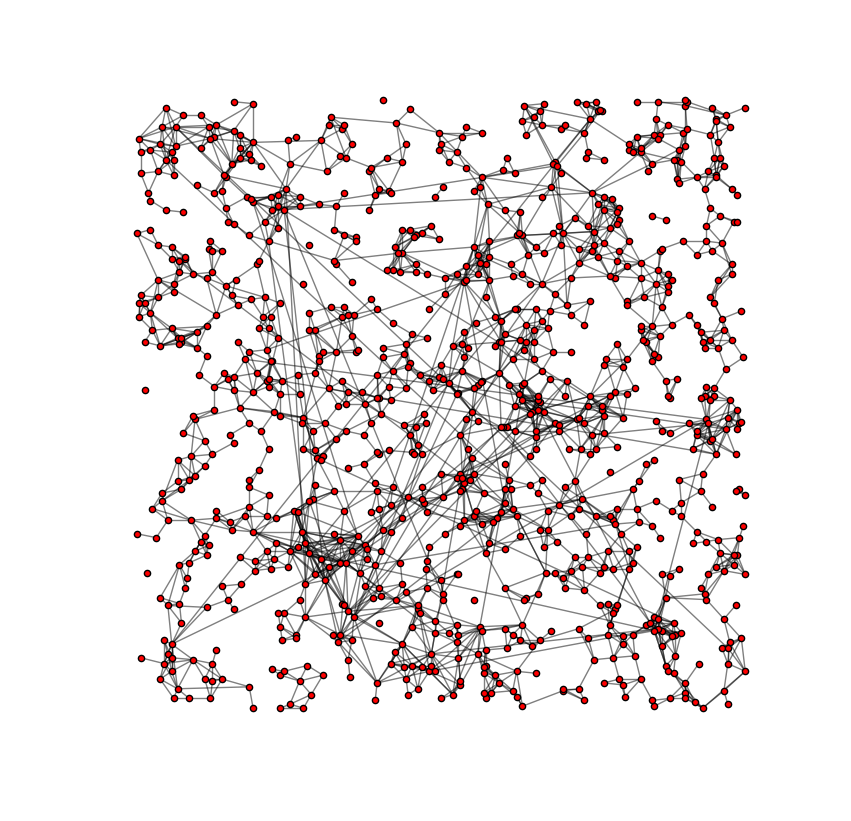

In [3]:
pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')

nx.draw_networkx_nodes(gp.G, pos, node_size=20, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

In [4]:
gp.init_partitioner()

FENNEL partitioner loaded for generating PREDICTION MODEL.
FENNEL partitioner loaded for making shelter assignments.


# Prediction Model

In [5]:
m = gp.prediction_model()

PREDICTION MODEL
----------------


Assignments:
[ 0  1  2  3  4  5  0  1  2  3  4  5  0  1  2  0  3  4  5  1  5  2  3  4  0  1  2  3  4  5  0  1  2  3  2  4  5  0  1  2  3  4  5  1  0  2  3  4  5  0  1  2  3  4  0  5  1  2  3  4  5  0  1  2  1  3  1  1  4  5  0  4  3  2  2  4  2  5  2  0  3  5  0  0  3  1  4  2  5  0  3  4  1  5  2  3  4  5  0  1  2  3  4  5  5  0  4  1  2  3  0  1  2  3  3  4  5  1  0  0  2  4  5  1  3  3  2  0  4  4  5  1  3  2  5  3  4  0  0  1  2  4  5  5  3  1  2  5  0  4  1  2  5  0  2  1  4  4  1  3  3  0  2  5  4  0  3  3  4  2  5  4  1  1  0  1  2  5  0  2  0  3  4  4  5  2  1  3  1  1  3  0  0  5  5  0  2  3  2  2  4  2  5  2  1  2  4  3  4  5  0  1  5  4  0  3  5  0  5  2  5  5  0  1  3  1  3  5  5  2  3  3  4  2  0  5  0  0  1  4  5  0  1  5  0  1  4  0  3  3  3  4  1  2  2  4  1  5  3  1  0  5  5  3  4  4  2  2  1  4  2  0  1  4  4  3  4  5  1  3  4  5  3  0  5  0  0  4  1  2  5  1  2  2  5  3  2  3  0  2  1  0  3  1  3  2  3  4  2  3  2  3  0  4  4  0  4

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  0.014    0.24983        734                859    0.852788    0.800407   

  NETWORK PERMANENCE  
1           0.379307  


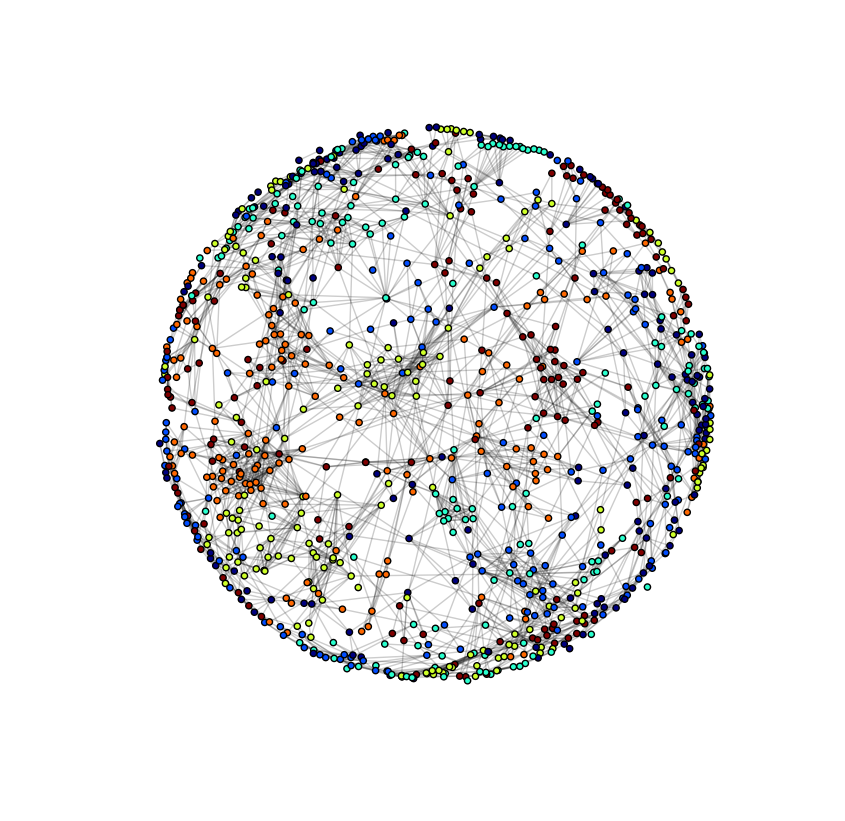

In [6]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

pos = nx.spring_layout(gp.G)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
#for n in gp.G.nodes_iter():
#    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=gp.assignments, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.2)
plt.show(gp.G)

# Assign Cut Off

In [7]:
m = gp.assign_cut_off()

Assign first 100 arrivals using prediction model, then discard


Assignments:
[-1 -1 -1 -1  4  5 -1 -1 -1 -1 -1 -1  0  1 -1 -1 -1  4  5 -1 -1 -1 -1 -1  0  1 -1 -1 -1  5 -1  1 -1  3 -1 -1 -1 -1  1 -1  3  4  5 -1 -1 -1 -1  4 -1 -1  1 -1 -1  4 -1  5  1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1  4  2  5 -1 -1 -1 -1 -1  0 -1  1  4 -1 -1 -1 -1 -1 -1  5 -1 -1 -1  5  0 -1 -1 -1 -1 -1 -1 -1  4 -1 -1  3 -1 -1  2 -1 -1  4 -1  1 -1 -1 -1  4  5  1 -1 -1 -1 -1  4 -1 -1  1 -1  2 -1  3 -1 -1 -1 -1 -1 -1 -1  5  3 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  4  4 -1 -1 -1 -1  2 -1  4 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1  2 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1  3 -1 -1 -1  2 -1 -1  1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  5 -1  1 -1  1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1  5  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  5  5 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  4  4 -1  4  5 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  5  3 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3 

In [8]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  0.044   0.158611        466                420    0.520676    0.493588   

  NETWORK PERMANENCE  
1           0.379307  


# Run Simulation

In [9]:
m = gp.batch_arrival()

Assigning in batches of 10
--------------------------------


Assignments:
[-1 -1 -1 -1  4  5 -1 -1 -1 -1 -1 -1  0  1 -1 -1 -1  4  5 -1 -1 -1 -1 -1  0  1 -1 -1 -1  5 -1  1 -1  3 -1 -1 -1 -1  1 -1  3  4  5 -1 -1 -1 -1  4 -1 -1  1 -1 -1  4 -1  5  1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1  4  2  5 -1 -1 -1 -1 -1  0 -1  1  4 -1 -1 -1 -1 -1 -1  5 -1 -1 -1  5  0 -1 -1 -1 -1 -1 -1 -1  4 -1 -1  3 -1 -1  2 -1 -1  4 -1  1 -1 -1 -1  4  5  1 -1 -1 -1 -1  4 -1 -1  1 -1  2 -1  3 -1 -1 -1 -1 -1 -1 -1  5  3 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  4  4 -1 -1 -1 -1  2 -1  4 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1  2 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  5 -1 -1 -1  3 -1 -1 -1  2 -1 -1  1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  5 -1  1 -1  1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1  5  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  5  5 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  4  4 -1  4  5 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  5  3 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3 -1 

    WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1   0.058   0.155340       16.0               24.0    0.540255    0.505886   
2   0.066   0.145299       17.0               26.0    0.621181    0.525840   
3   0.068   0.173611       25.0               40.0    0.666098    0.562185   
4   0.070   0.186747       31.0               47.0    0.690607    0.576730   
5   0.060   0.179775       32.0               48.0    0.707434    0.587554   
6   0.068   0.192118       39.0               59.0    0.727629    0.610003   
7   0.058   0.187215       41.0               63.0    0.726006    0.619468   
8   0.072   0.182186       45.0               67.0    0.731148    0.644087   
9   0.062   0.203571       57.0               80.0    0.712118    0.652018   
10  0.070   0.222571       71.0              103.0    0.721105    0.668606   
11  0.066   0.233429       81.0              118.0    0.722703    0.672642   
12  0.062   0.236074       89.0              128.0    0.724500  

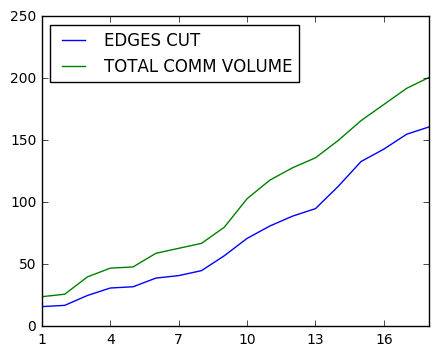

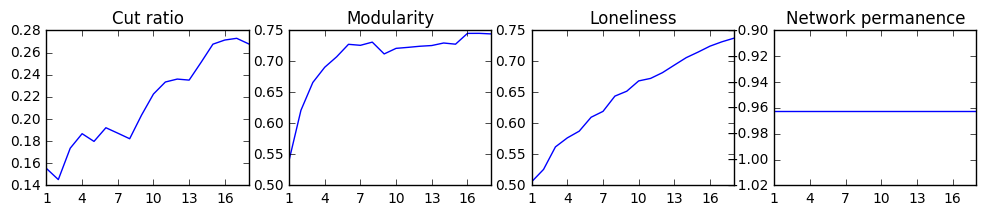

In [10]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

if len(df) > 1:
    t = int(len(rows) / 5)
    xticks = rows[::t]
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=xticks, figsize=(5,4))

    fig, axs = plt.subplots(1,5)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=xticks, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['MODULARITY'], title='Modularity', xticks=xticks, figsize=(12,2), legend=False, ax=axs[1])
    df.plot(y=['LONELINESS'], title='Loneliness', xticks=xticks, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NETWORK PERMANENCE'], title='Network permanence', xticks=xticks, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['NORM. MUTUAL INFO'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])
else:
    print("\n\nNot enough data points to plot charts. There is only one row.")

# Network Visual

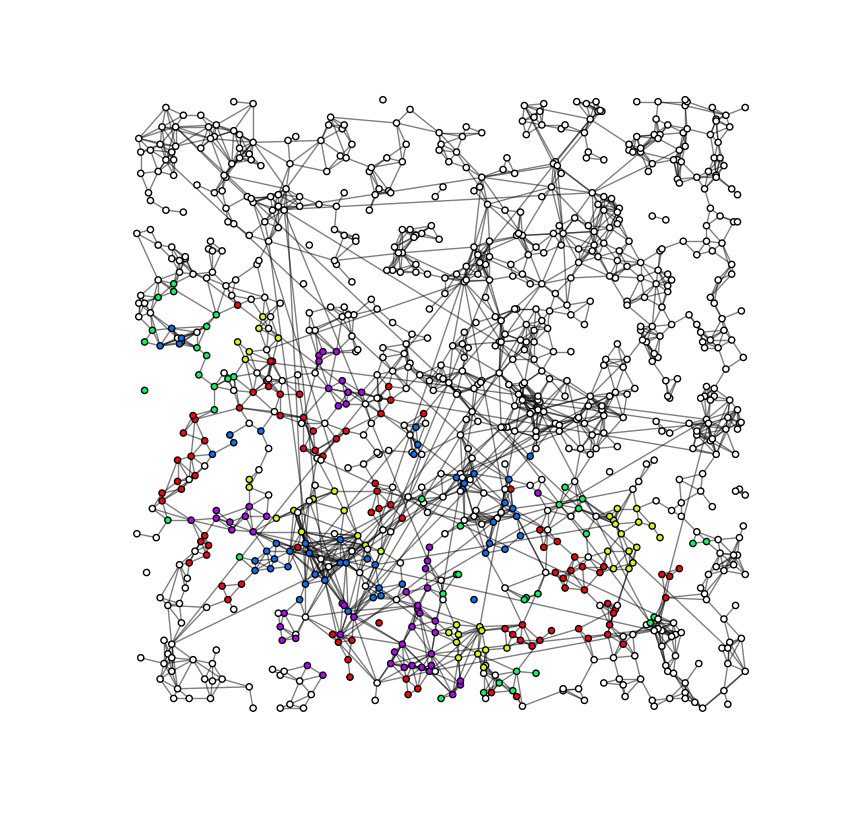

In [11]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos_spring = nx.spring_layout(gp.G, k=0.5, iterations=20)

pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

# create colours
cmap = utils.get_cmap(gp.num_partitions)
colours = np.zeros((gp.G.number_of_nodes(), 4), dtype=np.float)
for i,n in enumerate(gp.G.nodes_iter()):
    if gp.assignments[n] == -1:
        col = [(1.0, 1.0, 1.0, 1.0)]
    else:
        col = [cmap(gp.assignments[n])]
    colours[i] = np.array(col, dtype=np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colours, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

#nx.draw_networkx_nodes(gp.G, pos_spring, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
#nx.draw_networkx_edges(gp.G, pos_spring, alpha=0.5)
#plt.show(gp.G)

# Metrics

In [12]:
if run_metrics:
    gp.get_metrics()

Complete graph with 1000 nodes

Config
-------

file: 133022
num_partitions: 6
num_iterations: 1
prediction_model_cut_off: 0.1
one_shot_alpha: 0.5
restream_batches: 10
use_virtual_nodes: False
virtual_edge_weight: 1.0

Metrics
-------

edges_cut: 669
waste: 0.03899999999999999
cut_ratio: 0.2277059223961879
total_communication_volume: 658
network_permanence: 0.379307
Q: -0.0012888323746351217
NQ: -71.08304949012187
Qds: -1.0000000000000053
intraEdges: 0.0
interEdges: 5.923387096774194
intraDensity: 0.0
modularity degree: -5876.0
conductance: 1.0
expansion: 5.923387096774194
contraction: 0.0
fitness: 0.0
QovL: -1.3097038146250008E-9

Partition 0 with 42 nodes
-----------------------------


Metrics
file: 133022
partition: 0
population: 42
Q: -0.031239669421487582
NQ: -3.738498204837491
Qds: -0.9999999999999997
intraEdges: 0.0
interEdges: 2.972972972972973
intraDensity: 0.0
modularity degree: -110.0
conductance: 1.0
expansion: 2.972972972972973
contraction: 0.0
fitness: 0.0
QovL: -2.28193